In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import warnings
import scipy.sparse as sp

# Ignore specific warnings from imblearn
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
# Load Data and Initial Cleaning
# Define the path to the dataset
file_path = "dataset/Dataset.csv"

# Load dataset with error handling
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: Dataset file not found at '{file_path}'. Please ensure the path is correct.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors

# Proceed only if the DataFrame was loaded successfully
if not df.empty:
    # Rename columns
    df = df.rename(columns={
        'Restaurant Name': 'name',
        'Cuisines': 'cuisines',
        'Average Cost for two': 'cost',
        'Has Online delivery': 'online_order',
        'Has Table booking': 'book_table',
        'Aggregate rating': 'rating',
        'Rating color': 'rating_color',
        'Rating text': 'rating_text',
        'Price range': 'price_range_cat',
        'Votes': 'votes'
    })

    # Drop rows where the target variable 'cuisines' is missing
    df.dropna(subset=['cuisines'], inplace=True)


In [12]:
# Handle Rare Cuisine Classes and Encode Target
if not df.empty and 'cuisines' in df.columns:
    # Ensure the 'cuisines' column is treated as string data
    df['cuisines'] = df['cuisines'].astype(str)

    # Filter out cuisine classes with very few samples
    min_samples_threshold = 10 # Define the minimum number of restaurants required for a cuisine class
    cuisine_counts = df['cuisines'].value_counts()
    cuisines_to_keep = cuisine_counts[cuisine_counts >= min_samples_threshold].index
    df = df[df['cuisines'].isin(cuisines_to_keep)].copy() # Use .copy() to avoid SettingWithCopyWarning

    # Encode the target variable 'cuisines' into numerical labels
    if not df['cuisines'].empty:
        le = LabelEncoder()
        df['cuisine_encoded'] = le.fit_transform(df['cuisines'])
        # Store the mapping from cuisine name to encoded label for later interpretation
        cuisine_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    else:
        print("Warning: 'cuisines' column is empty after filtering. Cannot encode.")
        df = pd.DataFrame() # Clear df to prevent errors

else:
    print("DataFrame is empty or 'cuisines' column is missing. Cannot handle rare classes or encode target.")
    if 'df' in locals() and not isinstance(df, pd.DataFrame):
         df = pd.DataFrame()
    elif 'df' not in locals():
         df = pd.DataFrame()


In [13]:
# Prepare Features (Numerical, Categorical, and Text)
# Proceed only if the DataFrame is not empty and the target has been encoded
if not df.empty and 'cuisine_encoded' in df.columns:

    # Define Feature Sets
    numerical_features = ['cost', 'rating', 'votes']
    categorical_features = ['online_order', 'book_table']
    text_feature_col = 'cuisines'

    # Impute Missing Values in Selected Feature Columns
    # Numerical features: Impute with median
    for col in numerical_features:
        if col in df.columns:
            if df[col].isnull().any():
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)

    # Categorical features: Impute with 'Unknown'
    for col in categorical_features:
         if col in df.columns:
             if df[col].isnull().any():
                 if df[col].dtype != 'object':
                     df[col] = df[col].astype(object)
                 df[col].fillna('Unknown', inplace=True)

    # Identify features actually available after checks
    available_numerical_features = [f for f in numerical_features if f in df.columns]
    available_categorical_features = [f for f in categorical_features if f in df.columns]

    # Feature Engineering: Create Text Features using TF-IDF
    X_text = None
    if text_feature_col in df.columns:
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=3000, ngram_range=(1, 1))
        X_text = tfidf_vectorizer.fit_transform(df[text_feature_col])


    # Feature Engineering: Handle Categorical Features using One-Hot Encoding
    X_cat_encoded = None
    if available_categorical_features:
        X_cat = df[available_categorical_features]
        try:
            X_cat_encoded = pd.get_dummies(X_cat, columns=available_categorical_features, drop_first=True, dummy_na=False)
        except Exception as e:
            print(f"Error during One-Hot Encoding: {e}")
            X_cat_encoded = None

    # Combine all feature types into a single feature matrix
    feature_list = []

    # Add numerical features
    if available_numerical_features:
        X_num = df[available_numerical_features].values
        if X_num.size > 0:
             feature_list.append(sp.csr_matrix(X_num))


    # Add encoded categorical features
    if X_cat_encoded is not None and not X_cat_encoded.empty:
         feature_list.append(sp.csr_matrix(X_cat_encoded.values))


    # Add TF-IDF text features
    if X_text is not None:
        feature_list.append(X_text)


    # Horizontally stack all sparse feature matrices
    if feature_list:
        X_combined = sp.hstack(feature_list, format='csr')
        y = df['cuisine_encoded'] # Define the target variable

        # Final Sanity Check: Ensure features and target align
        if X_combined.shape[0] != len(y):
            print(f"CRITICAL ERROR: Feature matrix ({X_combined.shape[0]} samples) and target ({len(y)} samples) have different lengths. Check data processing steps.")
            if 'X_combined' in locals(): del X_combined
            if 'y' in locals(): del y
    else:
        print("No features were successfully processed or combined. Cannot create combined feature matrix.")
        if 'X_combined' in locals(): del X_combined
        if 'y' in locals(): del y

else:
    print("DataFrame is empty or target column ('cuisine_encoded') is missing. Cannot prepare features.")
    if 'X_combined' in locals(): del X_combined
    if 'y' in locals(): del y


In [14]:
# Split Data and Apply SMOTE
# Proceed only if the combined feature matrix and target variable exist
if 'X_combined' in locals() and 'y' in locals():
    # Split data into training and testing sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y,
            test_size=0.25,
            random_state=42,
            stratify=y
        )


        # Apply SMOTE to the training data ONLY
        min_class_size_train = y_train.value_counts().min()
        smote_k = max(1, min(2, min_class_size_train - 1))

        # Check if any class is too small for SMOTE
        if min_class_size_train > smote_k :
            try:
                nn = NearestNeighbors(n_neighbors=smote_k)
                smote = SMOTE(random_state=42, k_neighbors=nn)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            except ValueError as e:
                print(f"Error applying SMOTE: {e}")
                X_train_resampled = X_train
                y_train_resampled = y_train
        else:
            print(f"Warning: Smallest class size ({min_class_size_train}) is not large enough for SMOTE with k={smote_k}. Proceeding without SMOTE.")
            X_train_resampled = X_train
            y_train_resampled = y_train

    except ValueError as e:
        print(f"Error during train_test_split: {e}")
        if 'X_train' in locals(): del X_train, X_test, y_train, y_test
        if 'X_train_resampled' in locals(): del X_train_resampled, y_train_resampled

else:
    print("Combined feature matrix ('X_combined') or target ('y') is not available. Cannot split data or apply SMOTE.")
    if 'X_train' in locals(): del X_train, X_test, y_train, y_test
    if 'X_train_resampled' in locals(): del X_train_resampled, y_train_resampled


In [15]:
# Select and Train the Model
# Proceed only if the (potentially resampled) training data is available
if 'X_train_resampled' in locals() and 'y_train_resampled' in locals() and X_train_resampled.shape[0] > 0:
    # Select a classification model: RandomForestClassifier
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )
    # Train the model
    model.fit(X_train_resampled, y_train_resampled)
else:
    print("Training data ('X_train_resampled', 'y_train_resampled') is not available or is empty. Cannot train the model.")
    if 'model' in locals(): del model


In [16]:
# Evaluate the Model
# Proceed only if the model was trained and the original test data exists
if 'model' in locals() and 'X_test' in locals() and 'y_test' in locals() and X_test.shape[0] > 0:
    # Make predictions on the ORIGINAL test set
    y_pred = model.predict(X_test)

    # Evaluate Model Performance
    print("\n--- Model Evaluation Results ---")

    # Ensure the LabelEncoder (le) and its mapping are available from Cell 3
    if 'le' in locals() and hasattr(le, 'classes_'):
        target_names = le.classes_ # Get the original cuisine names

        # Get unique labels present in either y_test or y_pred
        present_labels = np.unique(np.concatenate((y_test, y_pred)))

        # Filter target names to include only those present in the test/pred set
        valid_indices = [i for i in present_labels if i < len(target_names)]
        filtered_target_names = [target_names[i] for i in valid_indices]

        if not valid_indices:
             print("Warning: No valid labels found in test/predictions matching the encoder. Cannot generate report with names.")
             print(classification_report(y_test, y_pred, zero_division=0))
        else:
            try:
                # Generate classification report
                print(classification_report(y_test, y_pred, labels=valid_indices, target_names=filtered_target_names, zero_division=0))
            except Exception as e:
                 print(f"Error generating classification report with target names: {e}")
                 print("Showing report with encoded labels instead:")
                 print(classification_report(y_test, y_pred, zero_division=0))

    else:
         print("LabelEncoder 'le' not found or invalid. Showing report with encoded labels only:")
         print(classification_report(y_test, y_pred, zero_division=0))

    # Calculate overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

else:
    print("Model, test features ('X_test'), or test target ('y_test') is not available or test set is empty. Cannot evaluate the model.")

print("\n--- End of Core Workflow ---")


--- Model Evaluation Results ---
                                                                               precision    recall  f1-score   support

                                                                     American       1.00      1.00      1.00         8
                                                             American, Burger       1.00      1.00      1.00         3
                                                          American, Fast Food       1.00      1.00      1.00         5
                                     American, Fast Food, Salad, Healthy Food       1.00      1.00      1.00        16
                                                                        Asian       1.00      1.00      1.00         4
                                                               Asian, Chinese       1.00      1.00      1.00         2
                                                                       Bakery       1.00      1.00      1.00        55
             

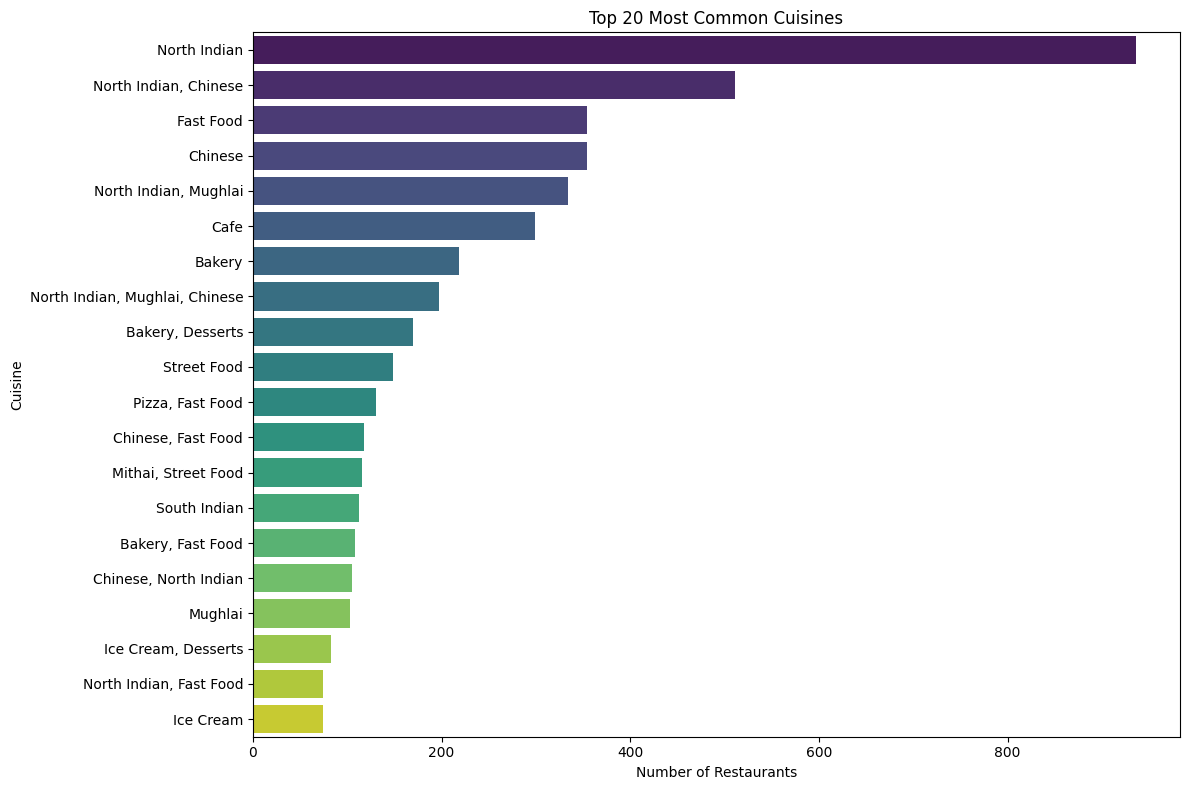

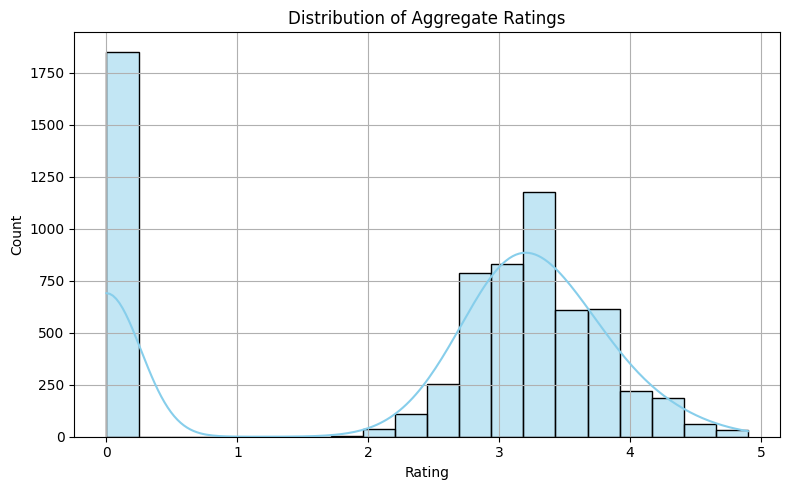

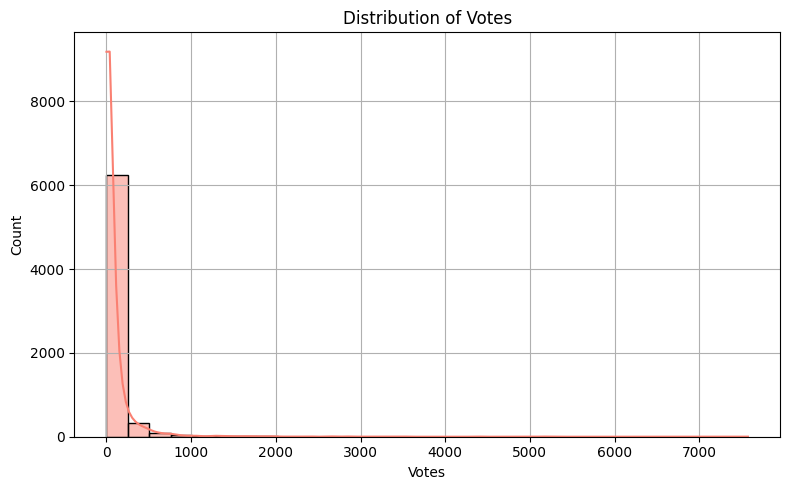

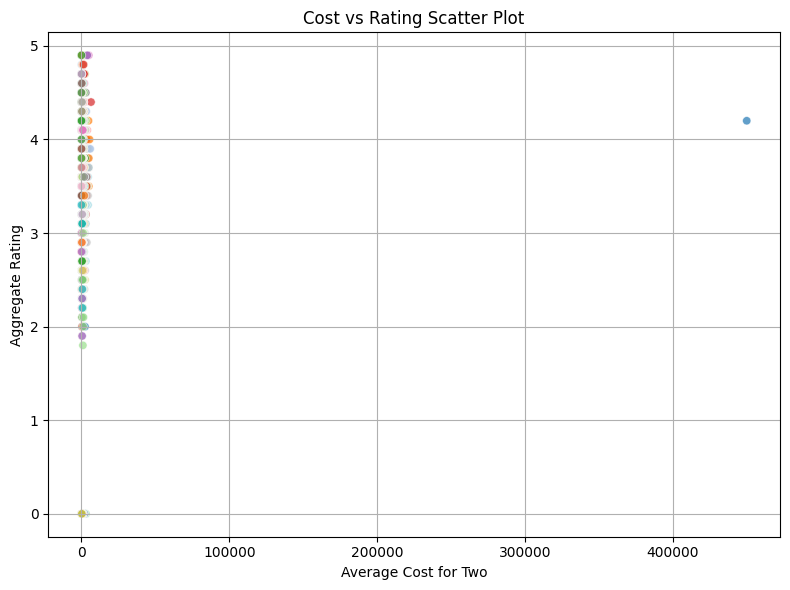

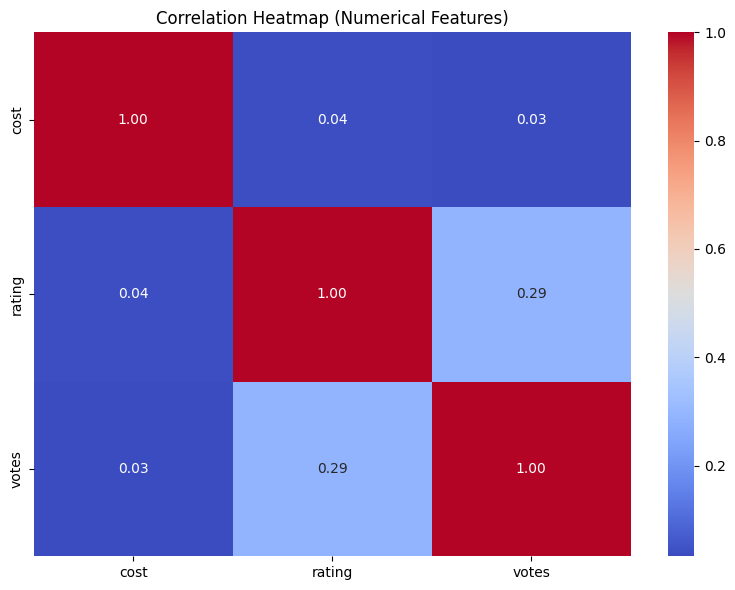

In [17]:
# --- Data Visualization for Cuisine Classification Task ---

import matplotlib.pyplot as plt
import seaborn as sns

# Proceed only if DataFrame is not empty
if not df.empty:

    # Step 1: Count the number of restaurants per cuisine
    cuisine_counts = df['cuisines'].value_counts()

    # Step 2: Select the top 20 cuisines
    top_20_cuisines = cuisine_counts.head(20)

    # Step 3: Create a DataFrame for easier plotting with hue
    cuisine_df = top_20_cuisines.reset_index()
    cuisine_df.columns = ['cuisine', 'count']

    # Step 4: Plot
    plt.figure(figsize=(12,8))
    sns.barplot(data=cuisine_df, x='count', y='cuisine', hue='cuisine', palette='viridis', legend=False)
    plt.title('Top 20 Most Common Cuisines')
    plt.xlabel('Number of Restaurants')
    plt.ylabel('Cuisine')
    plt.tight_layout()
    plt.show()

    # Rating Distribution
    if 'rating' in df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df['rating'], bins=20, kde=True, color='skyblue')
        plt.title('Distribution of Aggregate Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Count')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Votes Distribution
    if 'votes' in df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df['votes'], bins=30, kde=True, color='salmon')
        plt.title('Distribution of Votes')
        plt.xlabel('Votes')
        plt.ylabel('Count')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Scatter Plot: Cost vs Rating
    if 'cost' in df.columns and 'rating' in df.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=df, x='cost', y='rating', hue='cuisines', palette='tab20', legend=False, alpha=0.7)
        plt.title('Cost vs Rating Scatter Plot')
        plt.xlabel('Average Cost for Two')
        plt.ylabel('Aggregate Rating')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Correlation Heatmap
    numerical_cols = ['cost', 'rating', 'votes']
    available_numerical_cols = [col for col in numerical_cols if col in df.columns]

    if available_numerical_cols:
        plt.figure(figsize=(8, 6))
        corr_matrix = df[available_numerical_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap (Numerical Features)')
        plt.tight_layout()
        plt.show()

else:
    print("DataFrame is empty. Skipping data visualization.")
